In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import imgaug  
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils

import zipfile
import urllib.request
import shutil
# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log


# Path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")


Using TensorFlow backend.


In [2]:

class CocoConfig(Config):
    """Configuration for training on MS COCO.
    Derives from the base Config class and overrides values specific
    to the COCO dataset.
    """
    # Give the configuration a recognizable name
    NAME = "coco"
    #IMAGE_RESIZE_MODE = "square"
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1
    
    # Uncomment to train on 8 GPUs (default is 1)
    GPU_COUNT = 1
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # COCO has 80 classes

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32
    RPN_ANCHOR_RATIOS =  [0.5, 1, 4]
    RPN_ANCHOR_SCALES = (32, 64, 96, 128, 160)
    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 1500

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 2


In [3]:
############################################################
#  COCO Evaluation
############################################################

def build_coco_results(dataset, image_ids, rois, class_ids, scores, masks):
    """Arrange resutls to match COCO specs in http://cocodataset.org/#format
    """
    # If no results, return an empty list
    if rois is None:
        return []

    results = []
    for image_id in image_ids:
        # Loop through detections
        for i in range(rois.shape[0]):
            class_id = class_ids[i]
            score = scores[i]
            bbox = np.around(rois[i], 1)
            mask = masks[:, :, i]

            result = {
                "image_id": image_id,
                "category_id": dataset.get_source_class_id(class_id, "coco"),
                "bbox": [bbox[1], bbox[0], bbox[3] - bbox[1], bbox[2] - bbox[0]],
                "score": score,
                "segmentation": maskUtils.encode(np.asfortranarray(mask))
            }
            results.append(result)
    return results

In [4]:
def evaluate_coco(model, dataset, coco, eval_type="bbox", limit=0, image_ids=None):
    """Runs official COCO evaluation.
    dataset: A Dataset object with valiadtion data
    eval_type: "bbox" or "segm" for bounding box or segmentation evaluation
    limit: if not 0, it's the number of images to use for evaluation
    """
    # Pick COCO images from the dataset
    image_ids = image_ids or dataset.image_ids

    # Limit to a subset
    if limit:
        image_ids = image_ids[:limit]

    # Get corresponding COCO image IDs.
    coco_image_ids = [dataset.image_info[id]["id"] for id in image_ids]

    t_prediction = 0
    t_start = time.time()

    results = []
    for i, image_id in enumerate(image_ids):
        # Load image
        image = dataset.load_image(image_id)

        # Run detection
        t = time.time()
        r = model.detect([image], verbose=0)[0]
        t_prediction += (time.time() - t)

        # Convert results to COCO format
        # Cast masks to uint8 because COCO tools errors out on bool
        image_results = build_coco_results(dataset, coco_image_ids[i:i + 1],
                                           r["rois"], r["class_ids"],
                                           r["scores"],
                                           r["masks"].astype(np.uint8))
        results.extend(image_results)

    # Load results. This modifies results with additional attributes.
    coco_results = coco.loadRes(results)

    # Evaluate
    cocoEval = COCOeval(coco, coco_results, eval_type)
    cocoEval.params.imgIds = coco_image_ids
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()

    print("Prediction time: {}. Average {}/image".format(
        t_prediction, t_prediction / len(image_ids)))
    print("Total time: ", time.time() - t_start)

In [5]:
from samples.coco import coco
config = coco.CocoConfig()
COCO_DIR = './datasets/'  # TODO: enter value here

if config.NAME == 'shapes':
    dataset = shapes.ShapesDataset()
    dataset.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
elif config.NAME == "coco":
    dataset_train = coco.CocoDataset()
    dataset_train.load_coco(COCO_DIR,'train','201908')
    dataset_val = coco.CocoDataset()
    dataset_val.load_coco(COCO_DIR,'valid','201908')
# Must call before using the dataset
dataset_train.prepare()
dataset_val.prepare()
#print info
print("Image Count: {}".format(len(dataset_train.image_ids)))
print("Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))

print("Image Count: {}".format(len(dataset_val.image_ids)))
print("Class Count: {}".format(dataset_val.num_classes))
for i, info in enumerate(dataset_val.class_info):
    print("{:3}. {:50}".format(i, info['name']))

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Image Count: 4999
Class Count: 4
  0. BG                                                
  1. cone                                              
  2. rod                                               
  3. traffic_sign                                      
Image Count: 606
Class Count: 4
  0. BG                                                
  1. cone                                              
  2. rod                                               
  3. traffic_sign                                      


In [6]:
config = CocoConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [7]:
model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir='./logs')

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_conv1","mrcnn_class_bn1","mrcnn_class_conv2",'mrcnn_class_bn2',"mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])


In [9]:
'''
#augmentation = imgaug.augmenters.Fliplr(0.5)
# Training - Stage 1
print("Training network heads")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=40,
            layers='all',)
            #augmentation=augmentation)

# Training - Stage 2
# Finetune layers from ResNet stage 4 and up
print("Fine tune Resnet stage 4 and up")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=120,
            layers='4+',)
            #augmentation=augmentation)
print("Fine tune all layers")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=160,
            layers='all',)
            #augmentation=augmentation)
'''

'\n#augmentation = imgaug.augmenters.Fliplr(0.5)\n# Training - Stage 1\nprint("Training network heads")\nmodel.train(dataset_train, dataset_val,\n            learning_rate=config.LEARNING_RATE,\n            epochs=40,\n            layers=\'all\',)\n            #augmentation=augmentation)\n\n# Training - Stage 2\n# Finetune layers from ResNet stage 4 and up\nprint("Fine tune Resnet stage 4 and up")\nmodel.train(dataset_train, dataset_val,\n            learning_rate=config.LEARNING_RATE,\n            epochs=120,\n            layers=\'4+\',)\n            #augmentation=augmentation)\nprint("Fine tune all layers")\nmodel.train(dataset_train, dataset_val,\n            learning_rate=config.LEARNING_RATE / 10,\n            epochs=160,\n            layers=\'all\',)\n            #augmentation=augmentation)\n'

In [10]:
class InferenceConfig(CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use tf.cast instead.
Loading weights from  /home/pywu/peter/Mask_RCNN/logs/coco20190813T0837/mask_rcnn_coco_0160.h5
Re-starting from epoch 160


In [11]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max:  300.00000  float64
gt_class_id              shape: (4,)                  min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (4, 4)                min:   32.00000  max:  226.00000  int32
gt_mask                  shape: (256, 256, 4)         min:    0.00000  max:    1.00000  bool


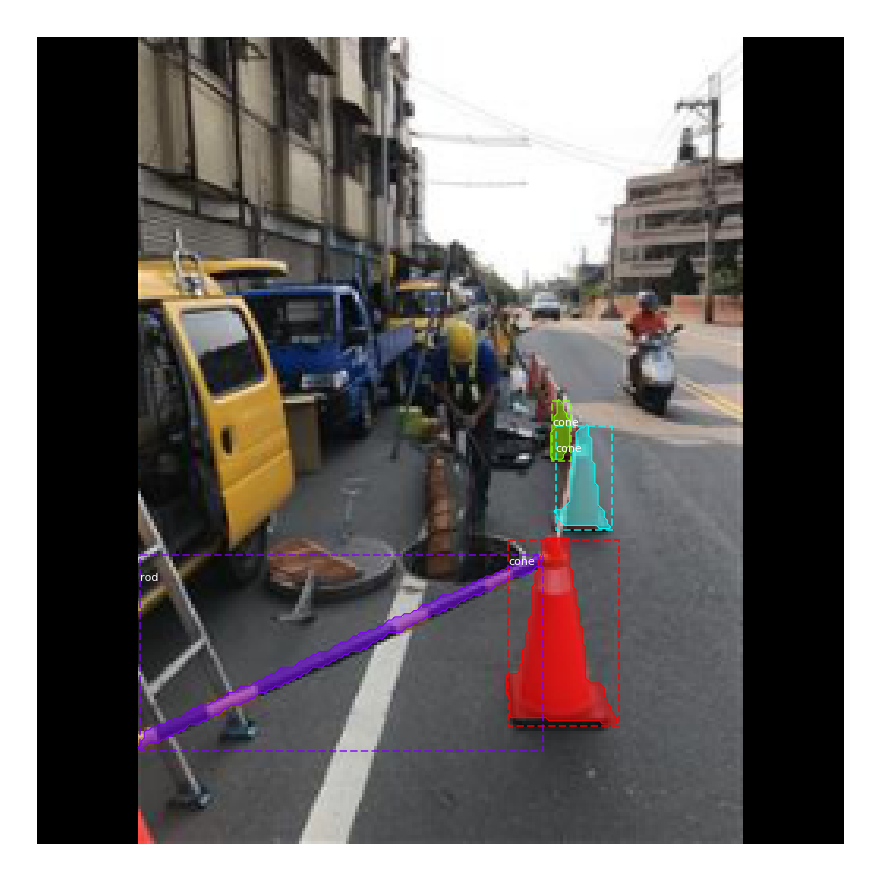

In [21]:
# Test on a random image
#image_id = 70
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(16,16))

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.62745  max:    1.37647  float32


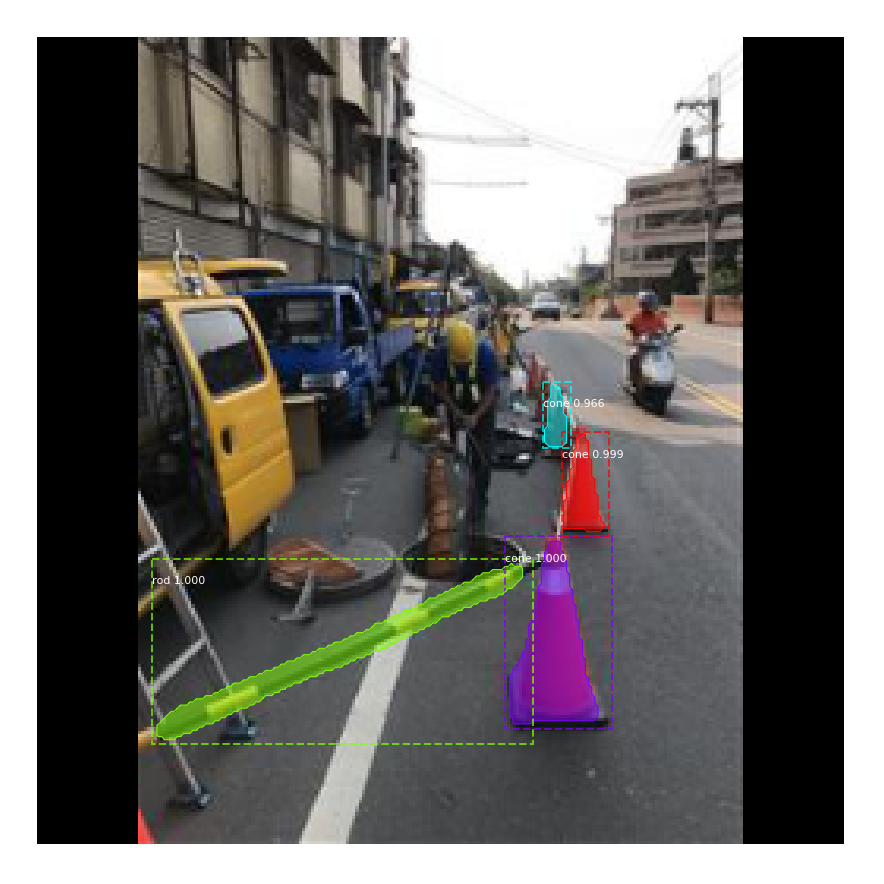

In [22]:
results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], figsize=(16,16))

In [14]:
coco = COCO(annotation_file='./datasets/annotations/instances_valid201908.json')
evaluate_coco(model, dataset_val, coco, "segm", limit=int(606))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.67s).
Accumulating evaluation results...
DONE (t=0.08s).
category : 0 : 0.39540009777176544
category : 1 : 0.1385062869605831
category : 2 : 0.5183828242495105
(all categories) mAP : 0.35076306966061965
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.351
category : 0 : 0.7859147098342846
category : 1 : 0.4218488809272964
category : 2 : 0.8242200527079022
(all categories) mAP : 0.6773278811564944
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.677
category : 0 : 0.3510488626942819
category : 1 : 0.03709523632048082
category : 2 : 0.6232653597581157
(all categories) mAP : 0.3371364862576261
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.337
category : 0 : 0.2768313255859

In [15]:
coco = COCO(annotation_file='./datasets/annotations/instances_valid201908.json')
evaluate_coco(model, dataset_val, coco, "bbox", limit=int(606))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.59s).
Accumulating evaluation results...
DONE (t=0.08s).
category : 0 : 0.4106190455222467
category : 1 : 0.20301466907161642
category : 2 : 0.482781583866148
(all categories) mAP : 0.36547176615333704
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.365
category : 0 : 0.8121540695373429
category : 1 : 0.4495868261323103
category : 2 : 0.8232176815695813
(all categories) mAP : 0.6949861924130781
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.695
category : 0 : 0.3769240115365447
category : 1 : 0.15693775181354097
category : 2 : 0.508691069830724
(all categories) mAP : 0.34751761106026996
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.348
category : 0 : 0.30340974837463

In [16]:
APs = []
for image_id in dataset_val.image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([original_image], verbose=0)
    r = results[0]

    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
print("mAP: ", np.mean(APs) * 100, "%")

mAP:  73.41904903606948 %
